In [24]:
import ipdb
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import os
import pickletools
from grid2op import Episode
from collections import namedtuple, Counter
import random

from typing import Union, List, Tuple, Optional
import imitation_data_loading
from imitation_data_loading import preprocess_observation, action_identificator, Episode, EpisodeStep, EpisodeSet
import torch
from grid2op.PlotGrid import PlotMatplot
import os
from grid2op import make
import grid2op

In [25]:
DATA_PATH='./Data/sample_training_episodes'

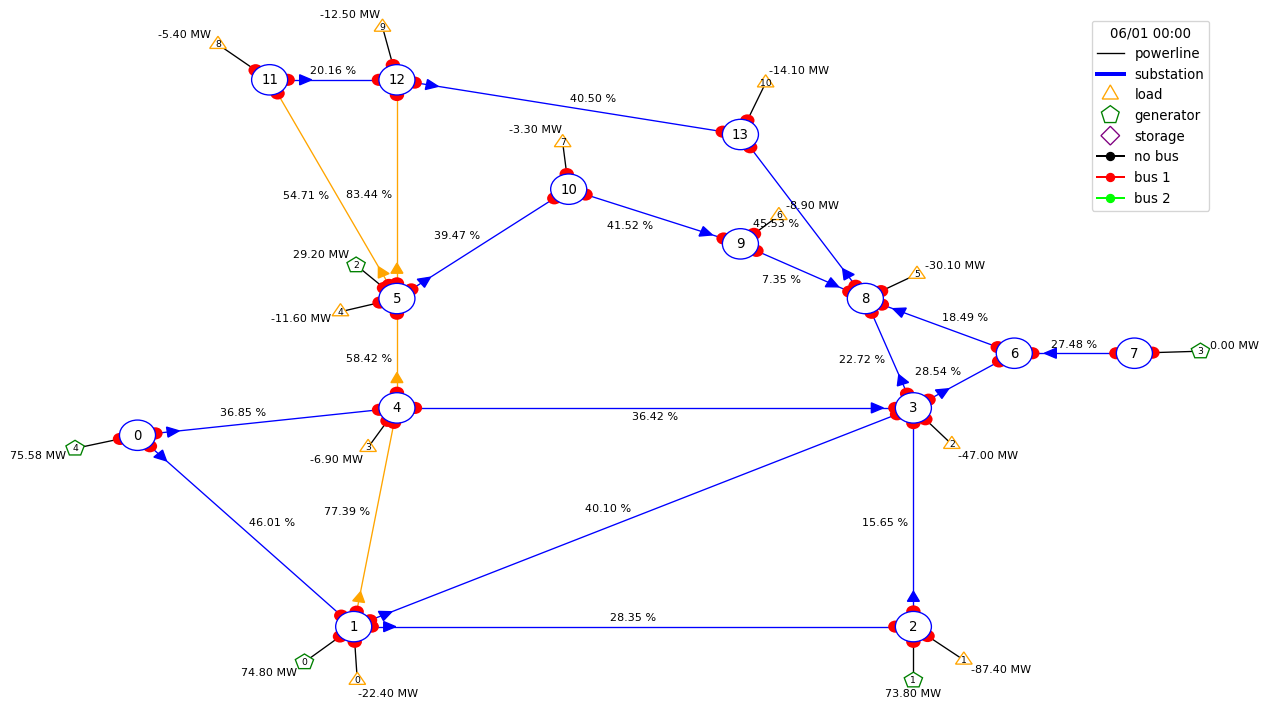

In [26]:
# Initialize the env.
env = make("rte_case14_realistic")
obs_space = env.observation_space

plot_helper = PlotMatplot(env.observation_space)

obs = env.reset()
fig = plot_helper.plot_obs(obs)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
object_indices = np.argsort(np.concatenate([obs_space.gen_pos_topo_vect,obs_space.load_pos_topo_vect,
                                obs_space.line_or_pos_topo_vect,obs_space.line_ex_pos_topo_vect]))
object_indices = torch.tensor(object_indices,device=device,dtype=torch.long)  

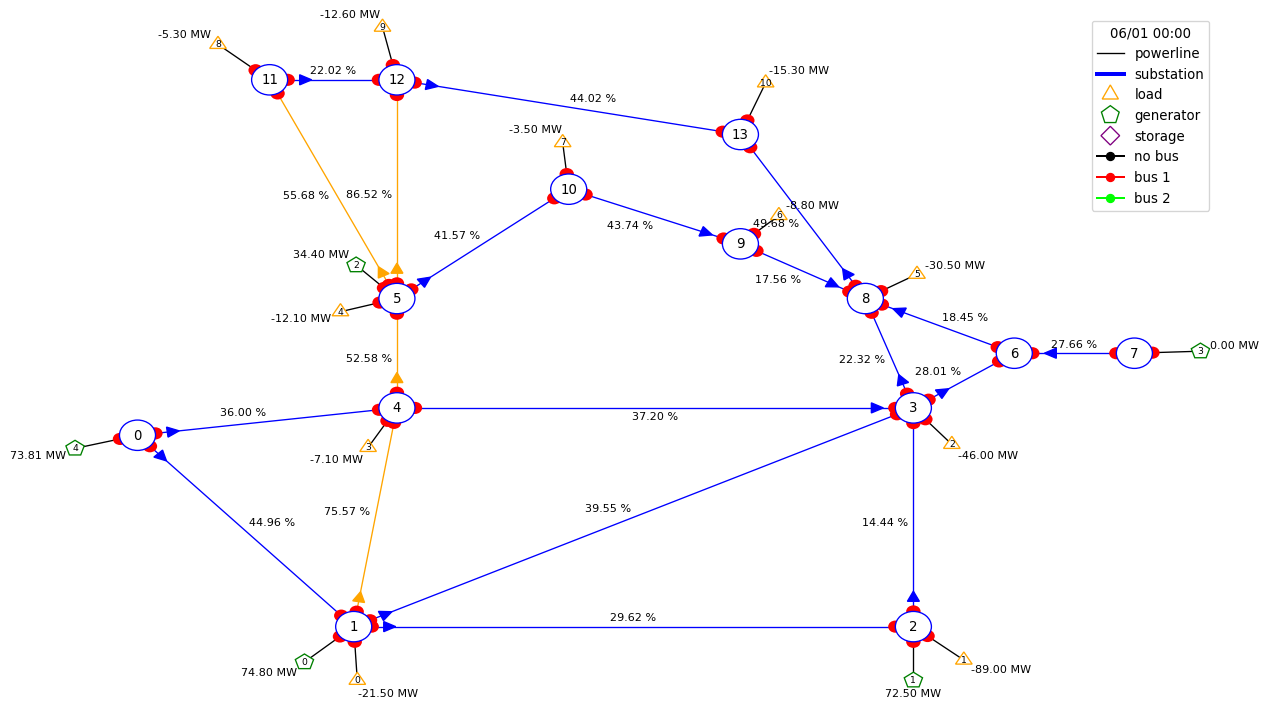

In [29]:
plot_helper = PlotMatplot(env.observation_space)

obs = env.reset()
fig = plot_helper.plot_obs(obs)

In [30]:
obs_space.line_or_pos_topo_vect

array([ 0,  1,  4,  5,  6, 10, 15, 24, 25, 26, 35, 36, 41, 47, 51, 16, 17,
       22, 31, 38], dtype=int32)

In [31]:
from torch_geometric.nn import  SAGEConv, Linear
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

#These indices are required from transferring from the order where different objects appear first \
#(gens, loads, ors, exs) to the order in the adjacency matrix

object_indices = np.argsort(np.concatenate([obs_space.gen_pos_topo_vect,obs_space.load_pos_topo_vect,
                                obs_space.line_or_pos_topo_vect,obs_space.line_ex_pos_topo_vect]))
object_indices = torch.tensor(object_indices,device=device,dtype=torch.long)  

f_gen, f_load, f_endpoint = 3,3,7 #Amount of features per object
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lin_gen_1 = Linear(f_gen,32)
        self.lin_gen_2 = Linear(32,32)
        
        self.lin_load_1 = Linear(f_load,32)
        self.lin_load_2 = Linear(32,32)
     
        self.lin_or_1 = Linear(f_endpoint,32)
        self.lin_or_2 = Linear(32,32)
        
        self.lin_ex_1 = Linear(f_endpoint,32)
        self.lin_ex_2 = Linear(32,32)
        
        self.conv1 = SAGEConv(32,32,root_weight=True,aggr='add')
        self.conv2 = SAGEConv(32,1,root_weight=True,aggr='add')
        

    def forward(self, x_gen, x_load, x_or, x_ex, edge_index):
        
        ### Linear layers for different objects ###
        x_gen = self.lin_gen_1(x_gen)
        x_gen = torch.sigmoid(x_gen)
        x_gen = self.lin_gen_2(x_gen)
        x_gen = torch.sigmoid(x_gen)
        x_load = self.lin_load_1(x_load)
        x_load = torch.sigmoid(x_load)
        x_load = self.lin_load_2(x_load)
        x_load = torch.sigmoid(x_load)
        x_or = self.lin_or_1(x_or)
        x_or = torch.sigmoid(x_or)
        x_or = self.lin_or_2(x_or)
        x_or = torch.sigmoid(x_or)
        x_ex = self.lin_ex_1(x_ex)
        x_ex = torch.sigmoid(x_ex)
        x_ex = self.lin_ex_2(x_ex)
        x_ex = torch.sigmoid(x_ex)
        
        ### Combining different objects ###
        x = torch.cat([x_gen,x_load,x_or,x_ex],axis=0)
        x = x[object_indices]

        ### Graph convolution layer ###
        x = self.conv1(x, edge_index)
        x = torch.sigmoid(x)
        x = self.conv2(x, edge_index)
        
        return torch.sigmoid(x)

In [32]:
from metrics import IncrementalAverage, IncrementalAverageMetrics, \
            correct_whether_changes, whether_changes, accuracy_if_changes 
    
metrics_dict = {
    'accuracy_whether_changes': (correct_whether_changes,IncrementalAverage()),
    'fraction_with_changes': (whether_changes,IncrementalAverage()),
    'accuracy_if_changes': (accuracy_if_changes ,IncrementalAverage())
}
metrics = IncrementalAverageMetrics(metrics_dict)

In [33]:

def get_changes(topo_vect,act):
    '''
    Given the current topology vector and a vector representing 'set' actions, 
    finds which object connections have changed.
    
    Parameters
    ----------
    topo_vect: np.array[int]
        The vector representing the current object connections. Each int represents the connection of a 
        single object to a busbar.
        A value of -1 indicates no connection; 1 a connection to the first busbar; 2 to the second busbar.
    act : np.array[int]
        A vector representing 'set' actions. Each int represent an action on an object-busbar connection.
        0 represents no change; 1 represents a set to the first busbar; 2 to the second.

    Returns
    -------
    set_idxs : np.array[int]
        Indices of set object-busbar connections.
    segt_objects : np.array[int]
        The busbar-object connections that have been set in the imitation example, 
        and whether that 'set' action caused a change. 0 represents no change; 1, change.
        The vector only represents the objects indexed by 'set_idxs'.
    any_changes : bool
        Whether the action changed any busbar-object connection.
    '''
    assert topo_vect.shape == act.shape
    assert all([x in [-1,1,2] for x in topo_vect])
    assert all([x in [0,1,2] for x in act])
        
    set_idxs = np.nonzero(act)[0]
    set_objects = np.abs(topo_vect[set_idxs] - act[set_idxs])
    any_changes = (np.count_nonzero(set_objects)!=0)
    return set_idxs, set_objects, any_changes

def custom_loss(out, set_idxs, changed_objects, any_changes,w_any=1,w_no=0.00):
    '''
    Custom loss
    '''
    if any_changes:
        return w_any*torch.nn.BCELoss()(out[set_idxs], changed_objects.float())
    else:
        return w_no*torch.nn.BCELoss()(out,torch.zeros(out.shape,device=device))
    

In [35]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#, weight_decay=5e-4)
n_epoch=1
act_ider = action_identificator()

In [ ]:


model.train()
for e in range(n_epoch):
    i=0
    for step in imitation_data_loading.DataIterator(DATA_PATH):
        _,step_attr = step
        obs = step_attr.observation
        act = act_ider.get_set_topo_vect(step_attr.action)
        
        
        X_gen, X_load, X_or, X_ex, topo_vect, connectivity_edges = \
              preprocess_observation(obs,env.observation_space)
        set_idxs, set_objects, any_changes = get_changes(topo_vect,act)
        
        X_gen, X_load, X_or, X_ex = \
                [torch.tensor(x,device=device,dtype=torch.float) for x in (X_gen, X_load, X_or, X_ex)]
        topo_vect, connectivity_edges, act, set_objects = \
                [torch.tensor(x,device=device,dtype=torch.long) for x in (topo_vect, connectivity_edges, 
                                                                          act,set_objects)]
        
        out = model(X_gen, X_load, X_or, X_ex, connectivity_edges).reshape((-1))
        loss = custom_loss(out, set_idxs, set_objects, any_changes)
        loss.backward()
        optimizer.step()
        
        metrics.log(any_changes=any_changes,out=out,set_idxs=set_idxs,set_objects=set_objects)
        
        if (not i%1000) and (i!=0):
            print(f'i: {i}')
            print(metrics)
            print()
            metrics.reset()
        i+=1
        

i: 1000
accuracy_whether_changes: 0.013986013986013986
fraction_with_changes: 0.999000999000999
accuracy_if_changes: 0.4044444444444445

